In [1]:
# install dependencies if they aren't
!pip install pytorch-lightning python-dotenv wandb==0.15.0 protobuf==3.20.3 s3fs==2025.5.1 --quiet

# install from git
!if [ -e ./diffusionpokemon ]; then rm -rf ./diffusionpokemon; fi
!git clone https://github.com/LongDangHoang/DiffusionPokemon ./diffusionpokemon

Cloning into './diffusionpokemon'...
remote: Enumerating objects: 426, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 426 (delta 92), reused 93 (delta 36), pack-reused 232 (from 1)
Receiving objects: 100% (426/426), 2.16 MiB | 22.12 MiB/s, done.
Resolving deltas: 100% (206/206), done.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("./diffusionpokemon")

import re
import os
import torch
import torch.nn as nn
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from typing import List, Dict, Optional, Union, Tuple
from pathlib import Path

from diffusionpokemon.models.autoencoder_blocks import TimeEmbedding
from diffusionpokemon.models.ddpm_unet import DDPMModel, DDPMUNet
from diffusionpokemon.utils.callbacks import SampleCallback, DenoiseMidwaySampleCallback
from diffusionpokemon.utils.datasets import create_train_test_datasets_from_path

from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, OneCycleLR

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    EarlyStopping, 
    StochasticWeightAveraging, 
    Callback, 
    ModelCheckpoint,
    LearningRateMonitor,
)

torch.manual_seed(314)
torch.cuda.manual_seed_all(314)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
print(f"Using torch version: {torch.__version__}")

Using cuda
Using torch version: 2.6.0+cu124


# Get data

In [10]:
## Define hyperparameters
from dotenv import load_dotenv
import json

ON_KAGGLE = False
if not load_dotenv():
    from kaggle_secrets import UserSecretsClient
    os.environ["WANDB_API_KEY"] = UserSecretsClient().get_secret("wandb_api")
    os.environ["AWS_ACCESS_KEY_ID"] = UserSecretsClient().get_secret("s3_aws_access_key")
    os.environ["AWS_SECRET_ACCESS_KEY"] = UserSecretsClient().get_secret("s3_aws_secret_access_key")
    ON_KAGGLE = True
    
import wandb

project_name = PROJECT_NAME = "diffusion-pokemon-lightning"

if config_json_filename := os.getenv("CONFIG_JSON_NAME", None):
    with open(config_json_filename, "r") as f:
        config = json.load(f)
else:
    config = dict(
        batch_size = 16,
        use_constant_lr = False,
        lr = 1e-4,
        num_epoch = 1_000,
        dropout = 0.0,
        overfit_batch = 0.0,
        weight_decay = 0.0,
        log_wandb = True,
        transfer_from_run_s3_path = None,
        resume_from_run = None,
        use_augmentation = True,
        accumulate_grad_batches = 8,
        ddpm__n_steps = 1_000,
        ddpm__input_image_channels = 3,
        ddpm__input_image_size = 64,
        unet__channels_mult = [1, 4, 4, 4, 4, 4],
        unet__is_attn = [False, False, False, True, True, True],
        unet__n_blocks = 12,
        unet__hidden_dim = 64,
        unet__use_conv_for_res_change = True,
        is_finetune = False,
        lr_scheduler__class = "CosineAnnealingLR",
        max_trainer_time_limit = "00:10:00:00",
    )

for k, v in config.items():
    if k not in globals() or globals()[k] != v:
        globals()[k] = v

# start a new wandb run to track this script
if log_wandb:
    wandb.login()

    if "run" not in globals():
        run = wandb.init(
            project=PROJECT_NAME,
            id=resume_from_run,
            resume="must" if resume_from_run else None,
            config={
                **config,
                "mode": "offline" if not log_wandb else "online"
            }
        )
        assert run is not None

# some common things
to_pil = v2.ToPILImage()

def make_normaliser(num_channels=1):
    return v2.Normalize([0.5]*num_channels, [1]*num_channels) # - 0.5 / 1

def make_inv_normaliser(num_channels=1):
    return v2.Compose([transforms.Normalize([-0.5]*num_channels, [1]*num_channels), lambda x: torch.clip(x, 0, 1)])

In [11]:
# data augmentation transforms
data_aug_transforms = []
if config["use_augmentation"]:
    data_aug_transforms = [
        v2.RandomApply([v2.RandomResizedCrop(scale=(0.5, 0.8), size=config["ddpm__input_image_size"])], p=0.1),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomApply([v2.ColorJitter(contrast=0.1, hue=0.4)], p=0.3),
    ]

dataset_transform = transforms.Compose([
    v2.Resize((config["ddpm__input_image_size"], config["ddpm__input_image_size"]), antialias=True),
    *data_aug_transforms,
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    make_normaliser()
])

#  load datasets
generator = torch.Generator(device="cpu").manual_seed(413)
_, train_dataset, test_dataset = create_train_test_datasets_from_path(dataset_path, transform=dataset_transform, use_transform_on_validation=False, random_state=413)

In [12]:
# split train valid
print(f"Train: {len(train_dataset)}, Valid: {len(test_dataset)}")

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=os.cpu_count() - 2,
    pin_memory=True,
)

valid_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=os.cpu_count() - 2,
    pin_memory=True,
)

# append steps_per_epoch
effective_batch_size = batch_size * (1 if accumulate_grad_batches is None else accumulate_grad_batches)
num_train_examples = len(train_dataset) if overfit_batch == 0.0 else (overfit_batch * batch_size)
steps_per_epoch = math.ceil(num_train_examples / effective_batch_size)
print("Number of steps per epoch:", f"{steps_per_epoch}")

Train: 2378, Valid: 125
Number of steps per epoch: 19


Input shape: torch.Size([3, 64, 64])


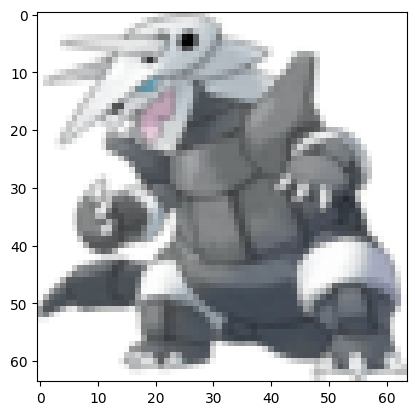

In [13]:
inv_t = make_inv_normaliser()

plt.imshow(to_pil(inv_t(test_dataset[12][0])))

print("Input shape:", test_dataset[0][0].shape)

# Init model

In [7]:
optimizer_kwargs=dict(
    use_constant_lr=config["use_constant_lr"],
    lr_scheduler__class=config["lr_scheduler__class"],
    lr=config["lr"],
    weight_decay=config["weight_decay"],
)

if config["lr_scheduler__class"] == "CosineAnnealingLR":
    optimizer_kwargs["lr_sched_freq__step"] = 1
    optimizer_kwargs["lr_scheduler__kwargs"] = {
        "T_max": config["num_epoch"] * steps_per_epoch,
        "eta_min": config["lr"] / 100
    }
elif config["lr_scheduler_class"] == "ReduceLROnPlateau":
    optimizer_kwargs["lr_sched_freq__step"] = steps_per_epoch
    optimizer_kwargs["lr_scheduler__kwargs"] = {
        "T_max": config["num_epoch"] * steps_per_epoch,
        "eta_min": config["lr"] / 100
    }

model = DDPMUNet(
    n_steps=config["ddpm__n_steps"],
    input_size=config["ddpm__input_image_size"],
    optimizers_kwarg=optimizer_kwargs,
    eps_model_kwargs=dict(
        n_blocks=config["unet__n_blocks"], 
        n_channels=config["unet__hidden_dim"],
        channels_mult=config["unet__channels_mult"], 
        is_attn=config["unet__is_attn"],
        res_block_dropout=config["dropout"],
        use_conv_for_res_change=config["unet__use_conv_for_res_change"],
        input_channels=config["ddpm__input_image_channels"]
    ),
    is_finetune=False,   # we're not interested in finetuning for a while...
).to(device)
       
print(f"Number of trainable params: {sum(p.numel() for p in model.eps_model.parameters() if p.requires_grad):,}")
print("Model device:", model.device)

print(optimizer_kwargs)

Number of trainable params: 235,098,755
Model device: cuda:0
{'use_constant_lr': False, 'lr_scheduler__class': 'CosineAnnealingLR', 'lr': 0.0001, 'weight_decay': 0.0, 'lr_sched_freq__step': 1, 'lr_scheduler__kwargs': {'T_max': 19000, 'eta_min': 1e-06}}


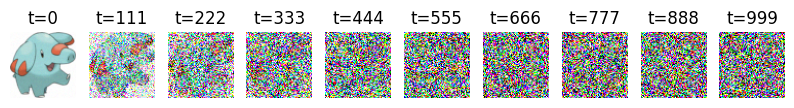

In [8]:
# test model forward noising
sample_img = train_dataset[13][0]

num_imgs = 10
ts = torch.as_tensor(np.round(np.linspace(0, model.n_steps-1, num_imgs)), dtype=torch.long).to(model.device)
x = torch.unsqueeze(sample_img, 0).expand(num_imgs, *sample_img.shape).to(model.device)
true_noise_e = torch.randn_like(x).to(model.device)
noised_x_t = model.noise_sample_at_timestep(x, ts, true_noise_e).cpu()

fig, axs = plt.subplots(ncols=num_imgs, nrows=1, figsize=(num_imgs, 1))
for idx, ax in enumerate(axs):
    ax.imshow(to_pil(inv_t(noised_x_t[idx])))
    ax.grid(False)
    ax.axis(False)
    ax.set_title(f"t={str(ts[idx].item())}")
    
plt.show()

In [ ]:
# test model denoising
out = model.sample(batch_size=1, input_channels=config["ddpm__input_image_channels"])
plt.imshow(to_pil(inv_t(out.cpu()[0])))

# Train

In [14]:
callbacks = [
    EarlyStopping(
        monitor="train_loss__step",
        min_delta=-float('inf'),       # always accept
        patience=5,
        verbose=False,
        check_finite=True,
        mode="min",
    ),
]
logger = None

validate_every_n_steps = (steps_per_epoch * config["num_epoch"]) // 100

if config["log_wandb"]:
    logger = WandbLogger(project=project_name, prefix="CIFAR")
    
    try:
        logger.watch(model)
    except ValueError as e:
        if "You can only call `wandb.watch` once per model." not in str(e):
            raise e
            
    callbacks.append(
        SampleCallback(
            logger=logger, 
            inv_normaliser=make_inv_normaliser(), 
            every_n_steps=validate_every_n_steps, 
            batch_size=4,
            input_channels=config["ddpm__input_image_channels"],
        )
    )
    callbacks.append(
        DenoiseMidwaySampleCallback(
            logger=logger, 
            seed_img_transformed=test_dataset[12][0],
            noise_at_ts=[100, 50, 10],
            every_n_steps=validate_every_n_steps,
            inv_normaliser=make_inv_normaliser()
        )
    )

    callbacks.append(
        ModelCheckpoint(
            dirpath=f"s3://deep-learning-personal-projects/{project_name}/{run.id}/",
            filename="{epoch}-{step}--valid_loss={valid_loss__epoch:.3f}",
            monitor="valid_loss__epoch",
            save_last=True,
            train_time_interval=datetime.timedelta(minutes=45),
            save_top_k=1,
            mode="min",
            enable_version_counter=False,
        )
    )

    callbacks.append(LearningRateMonitor(logging_interval='step'))


if config["transfer_from_run_s3_path"] and not config["resume_from_run"]:
    model = DDPMUNet.load_from_checkpoint(config["transfer_from_run_s3_path"])

trainer = Trainer(
    accelerator="gpu" if device == "cuda" else "cpu", 
    devices=1, 
    max_epochs=config["num_epoch"],
    log_every_n_steps=config["accumulate_grad_batches"], # if accumulate, reduce logging frequency since we only do one optimisation step after X batches
    precision=32,
    logger=logger,
    callbacks=callbacks,
    accumulate_grad_batches=config["accumulate_grad_batches"],
    overfit_batches=config["overfit_batch"],
    max_time=config["max_trainer_time_limit"],
    check_val_every_n_epoch=None,
    val_check_interval=validate_every_n_steps * config["accumulate_grad_batches"],
)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled   = True
torch.set_float32_matmul_precision("medium")

trainer.fit(
    model, 
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,   
    ckpt_path=(
        f"s3://deep-learning-personal-projects/{project_name}/{config['resume_from_run']}/last.ckpt" 
        if config["resume_from_run"]
        else None
    )
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined

In [ ]:
# test model denoising after training
out = model.sample(batch_size=1, input_channels=config["ddpm__input_image_channels"])
plt.imshow(to_pil(inv_t(out.cpu()[0])))

In [ ]:
if log_wandb:
    wandb.finish()